In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import imgaug

import sys
sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Microtubule")
data_dir = root_dir / "Data"
log_dir = root_dir / "Logs"
saved_model_dir = root_dir / "SavedModel"
log_file = root_dir / "current_training.log"

# Import the configuration associated with this dataset and network.
config = maskflow.load_config(root_dir / "config.yml")

Using TensorFlow backend.


# Load Training Dataset

In [2]:
# Split dataset
fnames = list((data_dir / "Image").glob("*.tif"))
#fnames = np.random.choice(fnames, 50)
train_fnames, validation_fnames = train_test_split(fnames, test_size=0.25)

# Build dataset
dataset_train = maskflow.MaskflowDataset()
dataset_train.set_dataset(train_fnames, config["CLASS_NAMES"])

dataset_val = maskflow.MaskflowDataset()
dataset_val.set_dataset(validation_fnames, config["CLASS_NAMES"])

print(f"train_fnames : {len(train_fnames)} | validation_fnames : {len(validation_fnames)}")

train_fnames : 954 | validation_fnames : 318


{'id': 84, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/preprocessed s4ch2 10uM hilyte 488 1 to 16 label ratio 10s-FLAT-T-105-C-1_AUGMENTED_9.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/preprocessed s4ch2 10uM hilyte 488 1 to 16 label ratio 10s-FLAT-T-105-C-1_AUGMENTED_9.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/preprocessed s4ch2 10uM hilyte 488 1 to 16 label ratio 10s-FLAT-T-105-C-1_AUGMENTED_9.csv')}


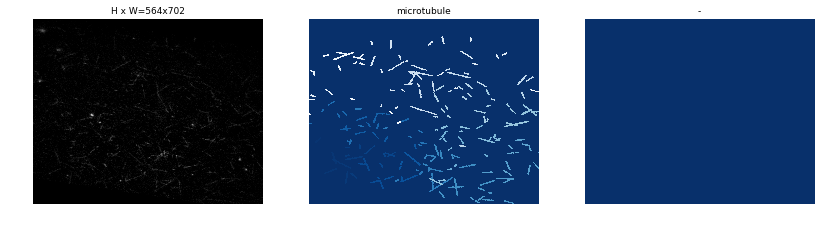

{'id': 775, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/image_snr_1.9_n-mts_160_id_43.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/image_snr_1.9_n-mts_160_id_43.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/image_snr_1.9_n-mts_160_id_43.csv')}


In [ ]:
dataset_train.random_display(n=2, n_class=2)

# Training

In [ ]:
maskflow_config = maskflow.MaskflowConfig(config)

maskflow_config.IMAGES_PER_GPU = 1
maskflow_config.GPU_COUNT = 1
maskflow_config.STEPS_PER_EPOCH = int(len(train_fnames) / maskflow_config.IMAGES_PER_GPU)

#maskflow_config.LOSS_WEIGHTS["mrcnn_class_loss"] = 2

maskflow_config.update()
maskflow_config.display()

In [ ]:
# Callback to execute during training
callbacks = []
callbacks.append(maskflow.FileLogger(str(log_file)))
callbacks.append(maskflow.TelegramLogger())

In [ ]:
model = maskflow.load_model(log_dir, maskflow_config, mode="training")

maskflow.load_weights(model, init_with="microtubule_detector20180624T1725")

# Copy config file to log directory
maskflow.save_config(config, Path(model.log_dir) / "config.yml")

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=maskflow_config.LEARNING_RATE,
            epochs=1000, layers='heads', custom_callbacks=callbacks)

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=maskflow_config.LEARNING_RATE,
            epochs=1000, layers='all', custom_callbacks=callbacks)

# Load Trained Model

In [4]:
training_name = "shapes_detector20180621T0950"

maskflow_config = maskflow.MaskflowConfig(config)
maskflow_config.IMAGES_PER_GPU = 1
maskflow_config.GPU_COUNT = 1
maskflow_config.update()

model = maskflow.load_model(log_dir, maskflow_config, mode="inference")
maskflow.load_weights(model, init_with=training_name)

# Load image with true predictions

{'id': 99, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Shapes/Data/Image/toy_0305.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Shapes/Data/Mask/toy_0305.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Shapes/Data/Class/toy_0305.csv')}


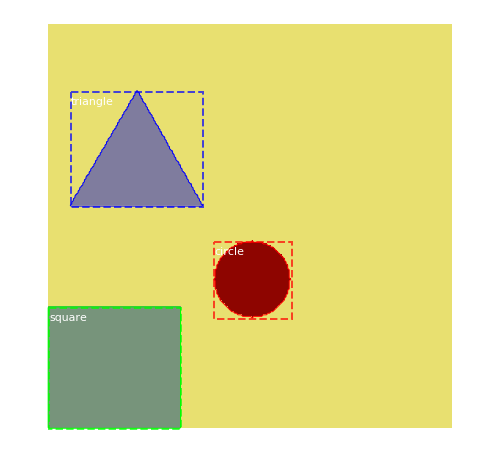

In [12]:
# Load a random image
image_id = np.random.choice(dataset_val.image_ids)
#image_id = 99

print(dataset_val.image_info[image_id])
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = maskflow.load_image_gt(dataset_val,
                                                                                   maskflow_config,
                                                                                   image_id,
                                                                                   use_mini_mask=False)

maskflow.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names, figsize=(8, 8))

# Predict

In [13]:
results = maskflow.predict(original_image, model, progress=True, verbose=0)

masked_images = maskflow.draw_results(original_image, results, model.config.CLASS_NAMES, colors=None, resize_ratio=1, draw_boxes=True, draw_masks=True, draw_contours=True, draw_score=True)
maskflow.show_images([[original_image], masked_images], size=10)

100%|██████████| 1/1 [00:00<00:00, 129.95it/s]


interactive(children=(IntSlider(value=0, description='t', max=0), Output()), _dom_classes=('widget-interact',)…

# Export trained model to ZIP

In [ ]:
model_name = "good_one"
maskflow.export_to_zip(model, model_name, saved_model_dir)